# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>

#### <center> **Final Project: Batch Processing** </center>
---

**Date**: October, 2025

**Student Name**: Juan Alonso

**Professor**: Pablo Camarillo Ramirez

# Introduction

In modern e-commerce, customers interact with products through purchases, reviews, and returns across different categories and brands. Managing and analyzing these interactions at scale helps companies detect behavior patterns, improve recommendations, and identify relationships between products and customers.

This project demonstrates a **batch-processing pipeline using Apache Spark** to process synthetic e-commerce data and build a knowledge graph of relationships among **Users**, **Products**, **Brands**, and **Categories**. The data is later persisted into **Neo4j**, a NoSQL graph database that enables efficient exploration of connections, such as “users who bought products from the same brand” or “categories with frequent returns.”  

The main goal is to showcase how distributed processing (Spark) and graph modeling (Neo4j) can together transform raw transactional data into insights that support better business decisions.


# Dataset

**Data model:** Graph-based.  
This model captures interactions as relationships among key entities:

- **User** → node representing each customer.  
- **Product** → node with attributes:  
  - `product_id`, `name`, `price`, `sku`, `brand`, `category`
- **Relationships:**
  - `(User)-[:PURCHASED]->(Product)` with properties `{count, total_spent, last_ts}`
  - `(User)-[:REVIEWED]->(Product)` with `{rating, last_ts}`
  - `(Product)-[:BY]->(Brand)`
  - `(Product)-[:IN_CATEGORY]->(Category)`

Synthetic data is produced using the custom Python script `fake_ecom.py`, which relies on the **Faker** library. It creates:
- `products.csv` — product catalog with 1,000 items.  
- `user_events.csv` — 50,000 random user interactions (purchases, reviews, returns, add-to-cart).  

These CSVs are stored in:

`/opt/spark/work-dir/data/juanalonso/ecom/`  

and later read by Spark for transformation and enrichment.

In [10]:
from importlib import reload
import juanalonso.fake_ecom
reload(juanalonso.fake_ecom)
from juanalonso.fake_ecom import FakeEcomGenerator


generator = FakeEcomGenerator()

print("Generating synthetic e-commerce data...")
products_df, events_df = generator.generate_and_save_all(
    path="/opt/spark/work-dir/data/juanalonso/ecom",
    n_products=1000,
    n_users=500,
    n_events=50000
)
print("Data generation completed successfully!")


Generating synthetic e-commerce data...
Data generation completed successfully!


In [12]:
!pwd
!ls -la /opt/spark/work-dir/data/juanalonso/ecom

print("\n=== Sample of generated data files ===")
!head -5 /opt/spark/work-dir/data/juanalonso/ecom/products.csv
!head -5 /opt/spark/work-dir/data/juanalonso/ecom/user_events.csv

/opt/spark/work-dir
total 3788
drwxr-xr-x 1 root root     512 Oct 27 03:31 .
drwxr-xr-x 1 root root     512 Oct 27 03:31 ..
-rw-r--r-- 1 root root   84855 Oct 27 04:28 products.csv
-rw-r--r-- 1 root root 3789941 Oct 27 04:28 user_events.csv

=== Sample of generated data files ===
product_id,name,price,sku,brand,category
prod_0000,Self-enabling analyzing emulation,321.52,Gp-1051,Doyle Ltd,down
prod_0001,Grass-roots static matrix,126.22,KE-3829,Garcia-James,we
prod_0002,Fully-configurable zero tolerance leverage,339.97,QB-6311,"Dyer, Potter and Mack",left
prod_0003,Multi-channeled interactive installation,297.29,zU-7010,"Mcclain, Miller and Henderson",rate
user_id,product_id,event_type,event_ts,session_id,price,rating
user_0015,prod_0171,purchase,2025-09-22 01:56:45.845962,session_199506,114.16,
user_0275,prod_0033,review,2025-08-20 00:23:48.845962,session_75673,,2.0
user_0380,prod_0799,return,2025-09-22 02:32:04.845962,session_129843,277.11,
user_0396,prod_0115,purchase,2025-08-24 04:42

In [ ]:
# Display basic information about the generated datasets
print("="*60)
print("DATASET GENERATION SUMMARY")
print("="*60)
print(f"Generated datasets:")
print(f"- Products: {len(products_df):,} records")
print(f"- User Events: {len(events_df):,} records")

print("\n" + "="*60)
print("SAMPLE PRODUCTS DATA")
print("="*60)
print(products_df.head(10))

print("\n" + "="*60)
print("SAMPLE USER EVENTS DATA")
print("="*60)
print(events_df.head(10))

print("\n" + "="*60)
print("DATA QUALITY CHECKS")
print("="*60)
print(f"Unique users: {events_df['user_id'].nunique():,}")
print(f"Unique products: {events_df['product_id'].nunique():,}")
print(f"Event types: {events_df['event_type'].unique()}")
print(f"Brands sample: {products_df['brand'].unique()[:8]}")
print(f"Categories sample: {products_df['category'].unique()[:8]}")

DATASET GENERATION SUMMARY
Generated datasets:
- Products: 1,000 records
- User Events: 50,000 records

SAMPLE PRODUCTS DATA
  product_id                                            name   price      sku  \
0  prod_0000               Self-enabling analyzing emulation  321.52  Gp-1051   
1  prod_0001                       Grass-roots static matrix  126.22  KE-3829   
2  prod_0002      Fully-configurable zero tolerance leverage  339.97  QB-6311   
3  prod_0003        Multi-channeled interactive installation  297.29  zU-7010   
4  prod_0004             Mandatory bi-directional encryption   51.38  iB-3387   
5  prod_0005  Enterprise-wide even-keeled Local Area Network  303.00  gd-3178   
6  prod_0006                  Streamlined needs-based access  359.43  FE-1326   
7  prod_0007                     Extended impactful approach  212.66  qY-2606   
8  prod_0008                 Persevering executive interface  142.70  sn-8723   
9  prod_0009                     Centralized optimal support  350

# Transformations and Actions

In [15]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Ecom Batch -> Neo4j") \
    .master("spark://spark-master:7077") \
    .config("spark.jars.packages", "org.neo4j:neo4j-connector-apache-spark_2.13:5.3.10_for_spark_3") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")
spark.conf.set("spark.sql.shuffle.partitions", "5") 

print("Spark initialized:", spark.version)
print("Available cores (defaultParallelism):", sc.defaultParallelism)

:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.5.3.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /root/.ivy2.5.2/cache
The jars for the packages stored in: /root/.ivy2.5.2/jars
org.neo4j#neo4j-connector-apache-spark_2.13 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-c9acf414-b692-45f5-b766-a3a3f277983a;1.0
	confs: [default]
	found org.neo4j#neo4j-connector-apache-spark_2.13;5.3.10_for_spark_3 in central
	found org.neo4j#neo4j-connector-apache-spark_2.13_common;5.3.10_for_spark_3 in central
	found org.neo4j#caniuse-core;1.3.0 in central
	found org.neo4j#caniuse-api;1.3.0 in central
	found org.jetbrains.kotlin#kotlin-stdlib;2.1.20 in central
	found org.jetbrains#annotations;13.0 in central
	found org.neo4j#caniuse-neo4j-detection;1.3.0 in central
	found org.neo4j.driver#neo4j-java-driver-slim;4.4.21 in central
	found org.reactivestreams#reactive-streams;1.0.4 in central
	found io.netty#netty-handler;4.1.

Spark initialized: 4.0.0
Available cores (defaultParallelism): 2


In [16]:
DATA_DIR = "/opt/spark/work-dir/data/juanalonso/ecom"

products_sdf = (
    spark.read
    .option("header", True)
    .option("inferSchema", True)
    .csv(f"{DATA_DIR}/products.csv")
)

events_sdf = (
    spark.read
    .option("header", True)
    .option("inferSchema", True)
    .csv(f"{DATA_DIR}/user_events.csv")
)

print("products_sdf rows:", products_sdf.count())
print("events_sdf rows:", events_sdf.count())
products_sdf.printSchema()
events_sdf.printSchema()

products_sdf rows: 1000
events_sdf rows: 50000
root
 |-- product_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- price: double (nullable = true)
 |-- sku: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- category: string (nullable = true)

root
 |-- user_id: string (nullable = true)
 |-- product_id: string (nullable = true)
 |-- event_type: string (nullable = true)
 |-- event_ts: timestamp (nullable = true)
 |-- session_id: string (nullable = true)
 |-- price: double (nullable = true)
 |-- rating: double (nullable = true)



In [17]:
from pyspark.sql.functions import col, to_timestamp

# Ensure event_ts is a timestamp
events_clean = events_sdf.withColumn("event_ts", to_timestamp(col("event_ts").cast("string")))

events_clean = events_clean.filter(col("event_type").isin("purchase", "add_to_cart", "review", "return"))

# Join product metadata (brand/category/price)
events_enriched = (
    events_clean.alias("e")
    .join(products_sdf.alias("p"), col("e.product_id") == col("p.product_id"), "left")
    .select("e.user_id", "e.product_id", "e.event_type", "e.event_ts", "e.session_id", "e.price", "e.rating",
            "p.name", "p.brand", "p.category")
)

print("Enriched sample:")
events_enriched.show(5, truncate=False)

Enriched sample:
+---------+----------+----------+--------------------------+--------------+------+------+---------------------------------------+--------------------------+--------+
|user_id  |product_id|event_type|event_ts                  |session_id    |price |rating|name                                   |brand                     |category|
+---------+----------+----------+--------------------------+--------------+------+------+---------------------------------------+--------------------------+--------+
|user_0015|prod_0171 |purchase  |2025-09-22 01:56:45.845962|session_199506|114.16|NULL  |Reduced neutral utilization            |Galloway-Wyatt            |nation  |
|user_0275|prod_0033 |review    |2025-08-20 00:23:48.845962|session_75673 |NULL  |2.0   |Secured foreground protocol            |Dyer, Potter and Mack     |down    |
|user_0380|prod_0799 |return    |2025-09-22 02:32:04.845962|session_129843|277.11|NULL  |Persevering mobile algorithm           |Rodriguez LLC           

In [18]:
from pyspark.sql.functions import when, sum as Fsum, max as Fmax, first

# 1) User <-> Product edges: purchase/return counts, total_spent, last_ts
user_product_edges = (
    events_enriched
    .filter(col("event_type").isin("purchase", "return"))
    .groupBy("user_id", "product_id")
    .agg(
        Fsum(when(col("event_type") == "purchase", 1).otherwise(0)).alias("purchases"),
        Fsum(when(col("event_type") == "return", 1).otherwise(0)).alias("returns"),
        Fsum(when(col("event_type") == "purchase", col("price")).otherwise(0.0)).alias("total_spent"),
        Fmax("event_ts").alias("last_ts")
    )
)

# 2) Reviews: latest rating per (user,product)
reviews = (
    events_enriched
    .filter(col("event_type") == "review")
    .groupBy("user_id", "product_id")
    .agg(
        Fmax("event_ts").alias("last_review_ts"),
        first("rating", ignorenulls=True).alias("rating")
    )
)

# 3) Product -> Brand and Product -> Category (deduped)
product_brand = products_sdf.select("product_id", "brand").dropDuplicates()
product_category = products_sdf.select("product_id", "category").dropDuplicates()

# Show counts to verify
print("user_product_edges rows:", user_product_edges.count())
print("reviews rows:", reviews.count())
print("product_brand rows:", product_brand.count())
print("product_category rows:", product_category.count())


user_product_edges rows: 24385
reviews rows: 12318
product_brand rows: 1000
product_category rows: 1000


In [19]:
print("User-Product edges sample:")
user_product_edges.show(5, truncate=False)

print("Reviews sample:")
reviews.show(5, truncate=False)

print("Product->Brand sample:")
product_brand.show(5, truncate=False)


User-Product edges sample:


+---------+----------+---------+-------+-----------+--------------------------+
|user_id  |product_id|purchases|returns|total_spent|last_ts                   |
+---------+----------+---------+-------+-----------+--------------------------+
|user_0424|prod_0435 |1        |0      |376.92     |2025-10-08 15:27:05.845962|
|user_0046|prod_0239 |0        |1      |0.0        |2025-09-30 19:51:53.845962|
|user_0373|prod_0143 |1        |0      |179.01     |2025-09-24 10:16:49.845962|
|user_0330|prod_0193 |0        |1      |0.0        |2025-08-26 21:08:11.845962|
|user_0439|prod_0233 |1        |0      |126.05     |2025-08-02 11:05:21.845962|
+---------+----------+---------+-------+-----------+--------------------------+
only showing top 5 rows
Reviews sample:
+---------+----------+--------------------------+------+
|user_id  |product_id|last_review_ts            |rating|
+---------+----------+--------------------------+------+
|user_0363|prod_0755 |2025-10-20 18:51:44.845962|4.0   |
|user_0263|p

In [ ]:
user_product_pdf = user_product_edges.toPandas()
reviews_pdf = reviews.toPandas()
product_brand_pdf = product_brand.toPandas()
product_category_pdf = product_category.toPandas()

print("Collected to pandas:")
print("user_product:", len(user_product_pdf))
print("reviews:", len(reviews_pdf))
print("product_brand:", len(product_brand_pdf))
print("product_category:", len(product_category_pdf))


Collected to pandas:
user_product: 24385
reviews: 12318
product_brand: 1000
product_category: 1000


# Persistence Data

We use **Neo4j**, a **NoSQL graph database**, because the relationships between users, products, brands, and categories are inherently **graph-structured**. Traditional relational databases are less efficient for queries that traverse multiple relationships.  

Neo4j is ideal here because it:
- Represents entities and connections natively as nodes and relationships.  
- Enables **fast traversal queries** (multi-hop recommendations, brand associations, product co-purchases).  
- Offers flexible schema evolution — new relationship types can be added without altering existing tables.  
- Integrates smoothly with Spark through connectors or driver APIs for batch persistence.

In [24]:
from neo4j import GraphDatabase

NEO4J_URI = "bolt://neo4j-iteso:7687"
NEO4J_USER = "neo4j"
NEO4J_PASSWORD = "neo4j@1234"

driver = GraphDatabase.driver(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))

# Ensure uniqueness constraints
CONSTRAINTS = [
    "CREATE CONSTRAINT IF NOT EXISTS FOR (u:User)   REQUIRE u.user_id IS UNIQUE",
    "CREATE CONSTRAINT IF NOT EXISTS FOR (p:Product) REQUIRE p.product_id IS UNIQUE",
    "CREATE CONSTRAINT IF NOT EXISTS FOR (b:Brand)  REQUIRE b.name IS UNIQUE",
    "CREATE CONSTRAINT IF NOT EXISTS FOR (c:Category) REQUIRE c.name IS UNIQUE",
]
with driver.session() as sess:
    for c in CONSTRAINTS:
        sess.run(c)
print("Neo4j constraints ensured.")

def chunk(df, size=2000):
    for i in range(0, len(df), size):
        yield df.iloc[i:i+size]

# 1) Upsert user->product purchases/returns
cypher_upsert_user_product = '''
UNWIND $rows AS row
MERGE (u:User {user_id: row.user_id})
MERGE (p:Product {product_id: row.product_id})
MERGE (u)-[r:PURCHASED]->(p)
  ON CREATE SET r.count = coalesce(row.purchases,0), r.returns = coalesce(row.returns,0), r.total_spent = coalesce(row.total_spent,0), r.last_ts = row.last_ts
  ON MATCH  SET r.count = coalesce(r.count,0) + coalesce(row.purchases,0),
                 r.returns = coalesce(r.returns,0) + coalesce(row.returns,0),
                 r.total_spent = coalesce(r.total_spent,0) + coalesce(row.total_spent,0),
                 r.last_ts = CASE WHEN row.last_ts > r.last_ts THEN row.last_ts ELSE r.last_ts END
'''
with driver.session() as sess:
    for part in chunk(user_product_pdf, 2000):
        sess.run(cypher_upsert_user_product, rows=part.to_dict("records"))
print("User->Product edges written to Neo4j.")

# 2) Upsert reviews
cypher_reviews = '''
UNWIND $rows AS row
MERGE (u:User {user_id: row.user_id})
MERGE (p:Product {product_id: row.product_id})
MERGE (u)-[r:REVIEWED]->(p)
  ON CREATE SET r.rating = row.rating, r.last_ts = row.last_review_ts
  ON MATCH  SET r.rating = row.rating, r.last_ts = CASE WHEN row.last_review_ts > r.last_ts THEN row.last_review_ts ELSE r.last_ts END
'''
with driver.session() as sess:
    for part in chunk(reviews_pdf, 2000):
        sess.run(cypher_reviews, rows=part.to_dict("records"))
print("Reviews written to Neo4j.")

# 3) Upsert product -> brand
cypher_prod_brand = '''
UNWIND $rows AS row
MERGE (p:Product {product_id: row.product_id})
MERGE (b:Brand {name: row.brand})
MERGE (p)-[:BY]->(b)
'''
with driver.session() as sess:
    for part in chunk(product_brand_pdf, 5000):
        sess.run(cypher_prod_brand, rows=part.to_dict("records"))
print("Product->Brand edges written to Neo4j.")

# 4) Upsert product -> category
cypher_prod_cat = '''
UNWIND $rows AS row
MERGE (p:Product {product_id: row.product_id})
MERGE (c:Category {name: row.category})
MERGE (p)-[:IN_CATEGORY]->(c)
'''
with driver.session() as sess:
    for part in chunk(product_category_pdf, 5000):
        sess.run(cypher_prod_cat, rows=part.to_dict("records"))
print("Product->Category edges written to Neo4j.")


Neo4j constraints ensured.
User->Product edges written to Neo4j.
Reviews written to Neo4j.
Product->Brand edges written to Neo4j.
Product->Category edges written to Neo4j.


In [23]:
with driver.session() as sess:
    r = sess.run("MATCH (u:User)-[r:PURCHASED]->(p:Product) RETURN count(r) AS total LIMIT 1")
    s = r.single()
    print("Approx number of PURCHASED relationships (sampled):", s["total"] if s else "N/A")

# Close driver when done
driver.close()


Approx number of PURCHASED relationships (sampled): 24385


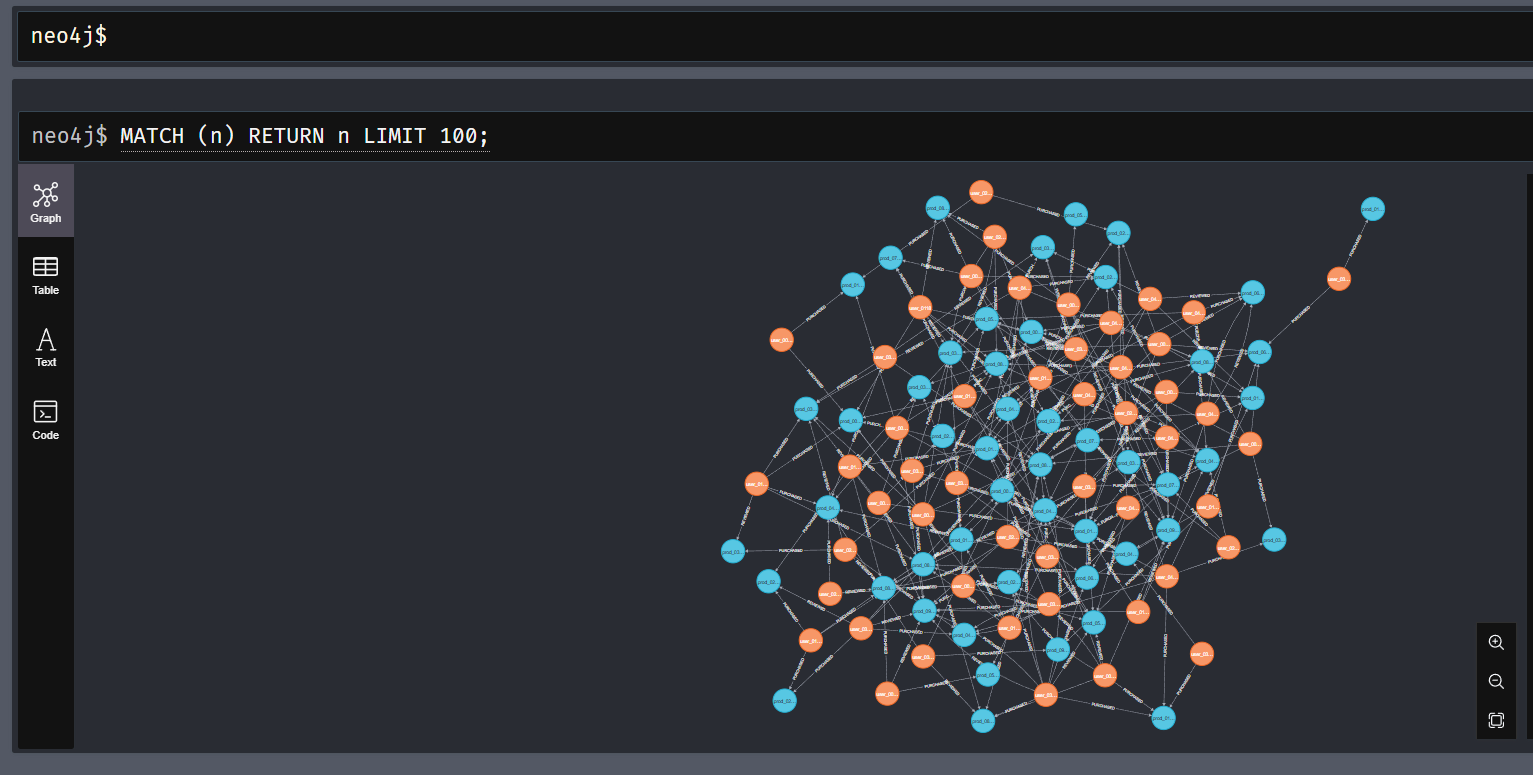

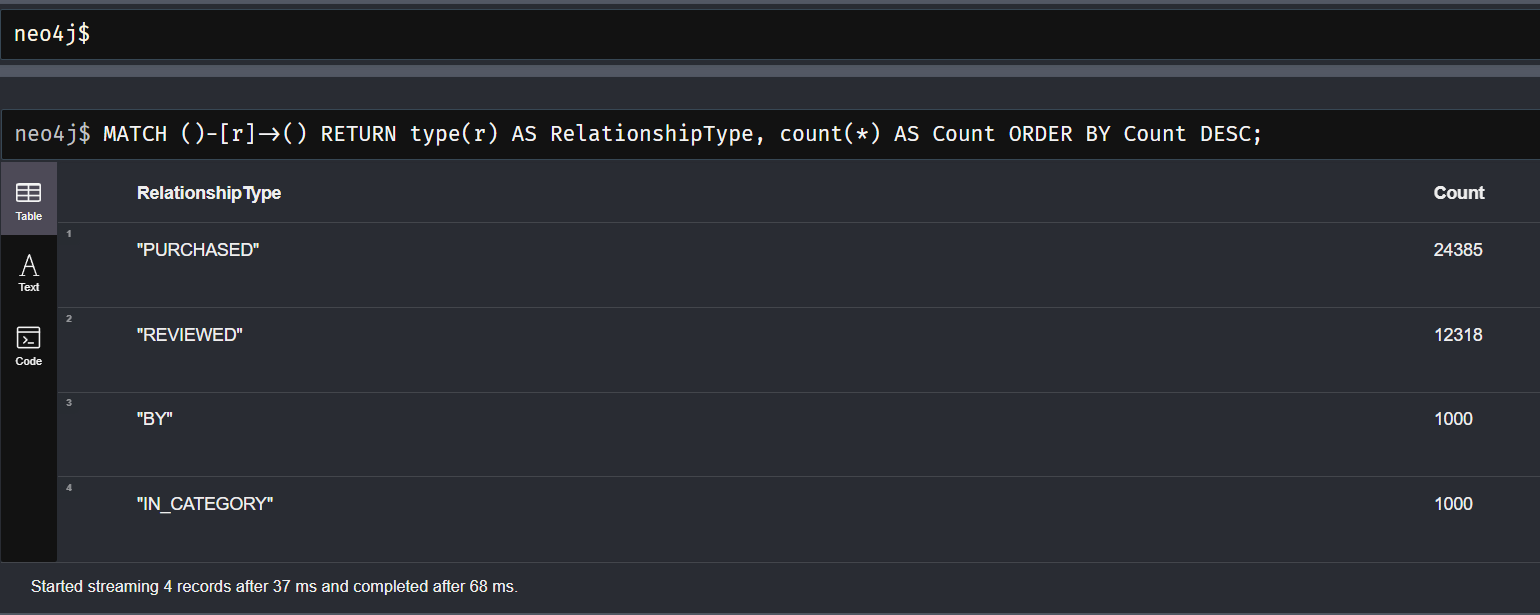

# DAG

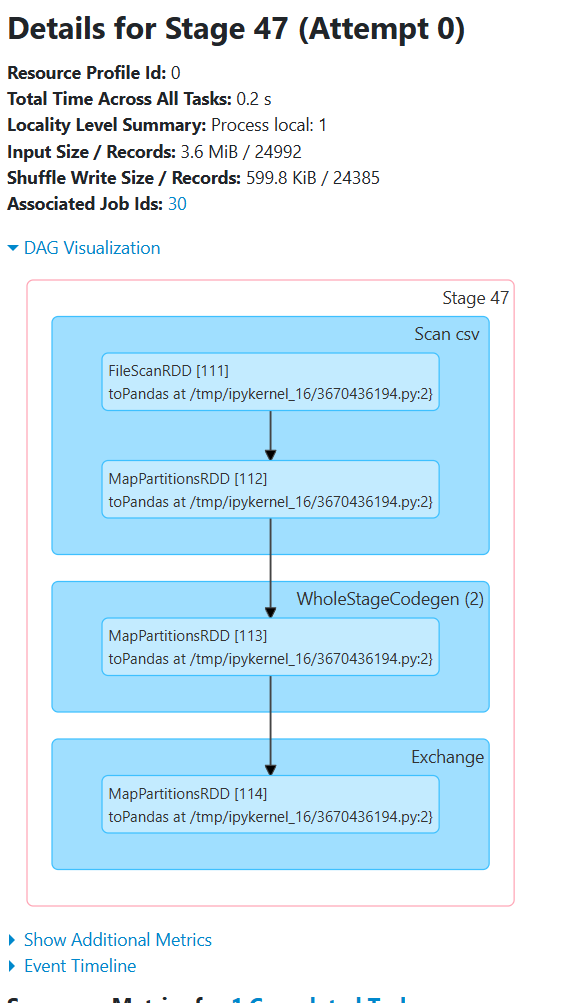

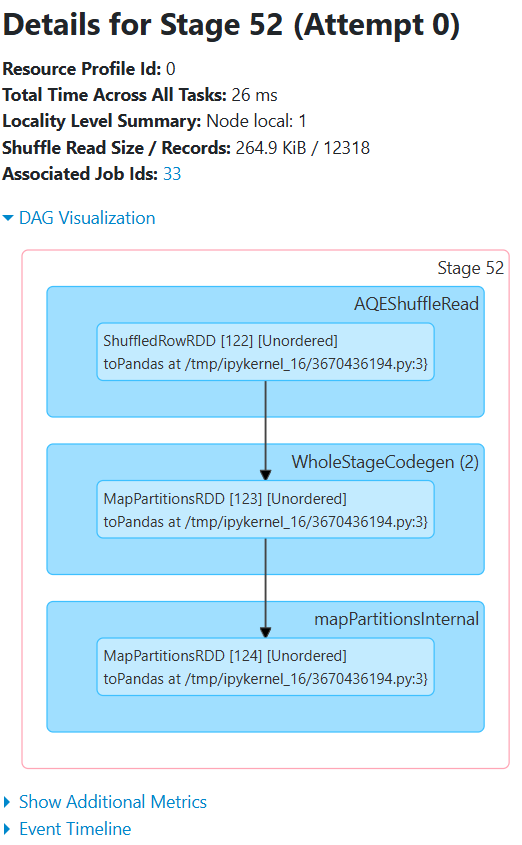

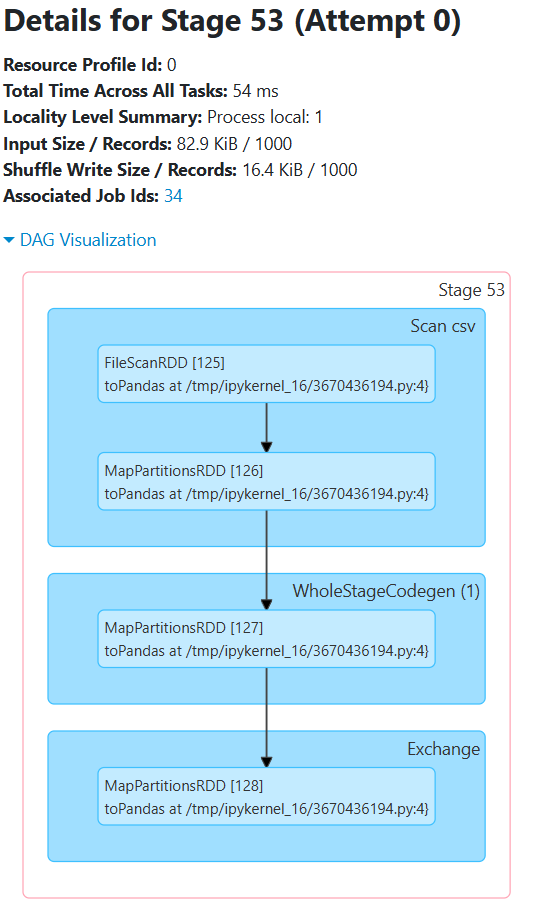

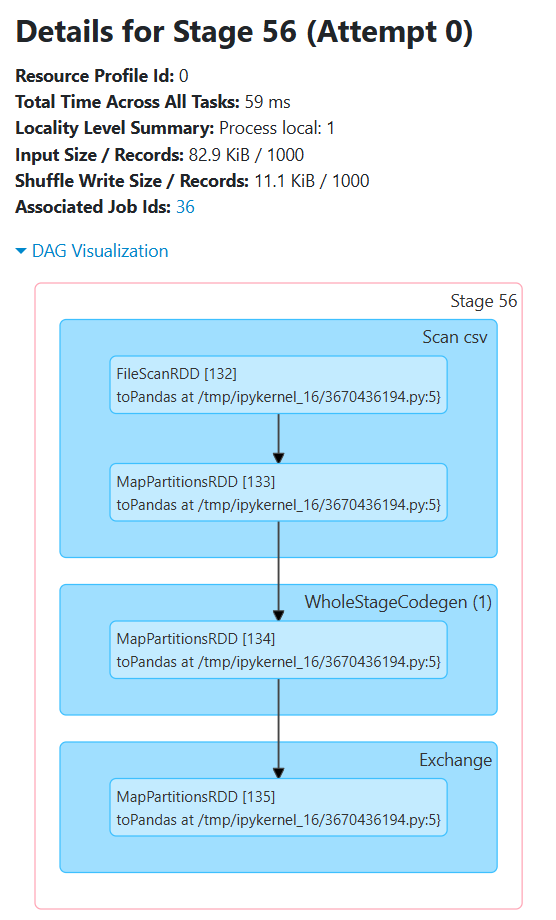

In [ ]:
spark.stop()